# Loading Libraries & Data
  First we need to load the necessary Python Libraries to parse the dataset:

In [ ]:
# Import necessary libraries.
import numpy as np
import pandas as pd
from sklearn import preprocessing
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
print("Setup Complete")

Setup Complete


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# import file urls from github:
composition_url = 'https://raw.githubusercontent.com/aabansal/AlgaeBiofuels/master/data/raw/ATP3-UFS-Composition.csv'
instrumentation_url = 'https://raw.githubusercontent.com/aabansal/AlgaeBiofuels/master/data/raw/ATP3-UFS-Instrumentation-daily.csv'
weather_url = 'https://raw.githubusercontent.com/aabansal/AlgaeBiofuels/master/data/raw/ATP3-UFS-Weather-daily.csv'
input_url = 'https://raw.githubusercontent.com/aabansal/AlgaeBiofuels/master/data/raw/ATP3-UFS-SummaryCombinedData.csv'

# Merging Data Files

For this analysis, we want to look at a multitude of factors in relation to algae cultivation. Specifically, we want to look at the production of usable Fatty Acid Methyl Esters (FAMEs), a type of lipid within the algae, for biofuel production. 
<br><br>
The original Kaggle notebook has different CSV files for each part of the dataset. For example, data relating to the biological composition of the algae (including FAME production) is saved as `'ATP3-UFS-Composition.csv'`. Harvest data is kept in the `'ATP3-UFS-SummaryCombinedData.csv'` file. Weather and Instrumentation data are kept in the `'ATP3-UFS-Instrumentation-daily.csv'`and `'ATP3-UFS-Weather-daily.csv'` files respectively. We need to combine these files into one csv in order to compare the factors that we are interested in.
<br><br> 
<small>*(For more background information on the dataset, visit the [ research presentation page ](https://www.nature.com/articles/sdata2018267). The original Kaggle notebook containing all csv files can be found [here](https://www.kaggle.com/stargarden/the-algae-testbed-publicprivate-partnership-atp3).)*
<br><br>



In [ ]:
# Import the CSV files as DataFrames (a type of two-dimensional data structure that we imported with the Pandas library)
composition_data = pd.read_csv(composition_url, index_col=0, parse_dates=['DATETIME'])
input_data = pd.read_csv(input_url, index_col=0, parse_dates=['DateTime'])
instrumentation_data = pd.read_csv(instrumentation_url, index_col = 0, parse_dates=['Date'])
weather_data = pd.read_csv(weather_url, index_col = 0, parse_dates=['Date'])

# Clean the Harvest Data
input_data= input_data[input_data['Analytical.Sample.ID'].notna()]

# We are going to start by merging Composition and harvest data
# First, let's prep the DataFrames for merging by setting the row index to a shared identifier: 'Analytical.Sample.ID' 
composition_data = composition_data.set_index("Analytical.Sample.ID")
input_data = input_data.set_index("Analytical.Sample.ID")

# Merge files into new DataFrame "combined_data"
combined_data = composition_data.merge(input_data)

# Clean up redundant and unnecessary columns
pd.DataFrame.drop_duplicates(combined_data)
combined_data = combined_data.drop(['NH4.mg.L', 'NH4.PCT.RSD', 'crash', 'Comments', 'OD680', 'OD680.PCT.RSD',
                                         'NO3.supplied.g', 'NO3.utilized.g', 'NO3.efficiency..', 'NH4.supplied.g',	'NH4.utilized.g',
                                         'NH4.efficiency..', 'P.supplied.g',	'P.utilized.g',	'P.efficiency..', 'mg.AFDW_mol.PAR.input',
                                         'mg.AFDW_kW.GLE.input'], axis=1).rename(columns={'DATETIME': 'Date'})

# Prepare other DataFrames for Merging by converting the datatype for the 'Date' column into dateTime
combined_data['Date'] = pd.to_datetime(combined_data['Date'], format='%d%b%Y')
combined_data['Date'] = combined_data['Date'].dt.date
instrumentation_data['Date'] = pd.to_datetime(instrumentation_data['Date'], format='%d%b%Y')
weather_data['Date'] = pd.to_datetime(weather_data['Date'], format='%d%b%Y')

# Rename SiteID column and re-index DataFrames 
combined_data['SiteID2'] = combined_data['SiteID']
combined_data = combined_data.set_index(['SiteID', 'PondID', 'Date'])
instrumentation_data = instrumentation_data.set_index(['SiteID', 'Date'])

#Merge the Data
mid_merge = instrumentation_data.merge(weather_data, left_index=True, right_on=['SiteID', 'Date'])
combined_data = combined_data.merge(mid_merge, left_index=True, right_on=['SiteID', 'PondID', 'Date'])

#export newly combined csv to google colab file repository
combined_data.to_csv("/content/Combined_Data.csv")

Our workspace is almost set up to begin working with the data. Let's just make sure everything worked... run the code cell below to open a preview of our combined_data

In [ ]:
combined_data.head()

Wow, this is a lot of data... and it is only 10 rows of the DataFrame (which is over 2,000 rows long). We also have 57 columns. Some of these columns are identifiers such as `'StrainID'`, `'SiteID'`, `'PondID'`, and `'Experiment ID'` that help us sort the data. Some other columns include actual data like `'Temp.C'`, `'pH_x'`, and `'RH(%)'` which are measurements taken of Temperature, pH, and relative humidity respectively.

Something that you may have noticed is that some of the columns have NA values. This is bound to happen when we combine files because of the frequency with which certain measurements are taken. For example, columns from our `'input_data'` include harvest data which can only be measured on days that the Algae was harvested. When we combine this type of data with `'Weather_data'`, which is taken daily, we will end up with some empty datapoints.

The following sections will work at making this data more understandable and accessible for analysis.

# Create Correlation Heatmaps
We have a large dataset with over 50 columns. To create a plot for each column and then look at a regression would be inefficient. In this section we will use Seaborn to produce correlation matrix heatmaps. This allows us to look at the relationships between many factors at once and specify which correlations we want to further investigate. 


We will be manipulating the data a lot so let's assign the combined Dataset to a new pandas dataframe object for this section. Let's also create new DataFrames for strain-specific analysis:

In [ ]:
# Reads in CSV file to a pandas DataFrame for manipulation:
df = pd.read_csv("/content/Combined_Data.csv", index_col=0)
list(df.columns)

# creates a single identifier specific to each pond within an experiment:
df['ExperimentPondID'] = df['ExperimentID.1'] + df['PondID']

# Create Datasets specific to each species based on 'StrainID' 
# As well as 'ALL' (all three species)
LRB = df.loc[df['StrainID_x'] == 'LRB-AZ-1201']
KA32 = df.loc[df['StrainID_x'] == 'KA32']
C046 = df.loc[df['StrainID_x']== 'C046']
ALL = df

Even though we dropped some columns when we merged CSVs, the DataFrame is still very big. Run the code cell below to see a list of our columns:

In [ ]:
df.columns

Index(['Protein.AF', 'FAME.Lipids.AF', 'Carbohydrates.AF', 'ExperimentID.1',
       'StrainID', 'SourceID', 'BatchID', 'Duration.days', 'DateTime',
       'TreatmentID', 'time.between.harvests.days', 'Harvest.',
       'Harvest.Vol..L.', 'AFDW..g.L.', 'AFDW..g.', 'Depth.cm',
       'Evaporation.Rate.cm.day', 'pH_x', 'Salinity', 'Temp.C', 'NO3.mg.L',
       'NO3.PCT.RSD', 'P.mg.L', 'P.PCT.RSD', 'N.P.ratio', 'Tracking.ID',
       'DW.g.L', 'DW.RSD', 'AFDW.g.L', 'AFDW.RSD', 'Ash', 'OD750',
       'OD750.PCT.RSD', 'NO3.demand.g.N.g.AFDW', 'NH4.demand.g.N.g.AFDW',
       'P.demand.g.P.g.AFDW', 'SiteID2', 'PondID', 'StrainID_x', 'pH_y',
       'Temp.avg (C)', 'Temp.max (C)', 'Temp.min (C)', 'Cond (mS.cm)',
       'DO (mg.L)', 'DO (%sat)', 'Sal (g.L)', 'PAR (umol.m2.s)', 'SiteID',
       'StrainID_y', 'Date', 'AirTemp(C)', 'RH(%)', 'GlobalLightEnergy(W.m2)',
       'WindSpeed(km.hr)', 'WDir(deg)', 'Precip.tot(cm)', 'ExperimentPondID'],
      dtype='object')

As you can see, in addition to a large number of columns, we have certain columns that wouldn't make sense for a heat map and won't help us effictively sort the data such as `'WDir(deg)'`, `'TrackingID'`, and `'TreatmendID'`. Let's trim down our data a little more:

In [ ]:
# Select columns to investigate.
col_list = ['Protein.AF',
 'FAME.Lipids.AF',
 'Carbohydrates.AF',
 'Duration.days',
 'time.between.harvests.days',
 'Harvest.Vol..L.',
 'AFDW..g.',
 'Depth.cm',
 'pH_x',
 'Temp.C',
 'NO3.mg.L',
 'P.mg.L',
 'OD750',
 'Temp.avg (C)',
 'Cond (mS.cm)',
 'DO (mg.L)',
 'DO (%sat)',
 'Sal (g.L)',
 'PAR (umol.m2.s)',
 'AirTemp(C)',
 'RH(%)',
 'GlobalLightEnergy(W.m2)',
 'WindSpeed(km.hr)',
 'Precip.tot(cm)']

# We will want to work with our original DataFrames later so we need to create
# heatmap-specific DataFrames...

# create dataFrame_fil variable for heatmaps ('df_fil' will be used for further 
# plots):
KA32_fil = KA32[col_list]
LRB_fil = LRB[col_list]
C046_fil = C046[col_list]
ALL_fil = ALL[col_list]
ALL_fil['StrainID'] = ALL['StrainID_x']
df_fil = df[col_list]

# ignore 'SettingWithCopyWarning'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Let's remember our focus: the cultivation of Algae for biofuels. In this dataset, FAMEs values are recorded under the `'FAME.lipids.AF'` column which records the amount of Ash-Free FAMEs as a percentage of algae biomass. (Ash-Free specifies the amount of FAMEs that will not turn into ash when burned)
<br><br>
Each heatmap shows the strength of a correlation as a color gradient.
Run the code cells below to generate the heatmaps and record any notable correlations for further investigation, paying special attention to `'FAME.lipids.AF'`.
<br><br><small>*You can double click the KA32 header to look at the code behind each heatmap. Click the three dots on the top right for that code cell and select "form"->"hide form" to hide the header*


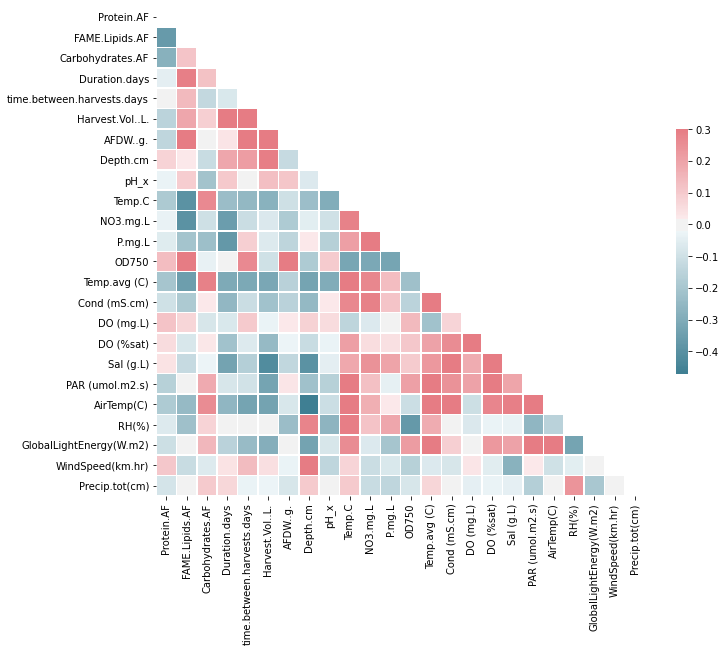

In [ ]:
#@title KA32 correlation heatmap

# Create correlation matrix using Pandas funtion .corr()
KA32_corr = KA32_fil.corr()

# Generate a mask for the top right so we only generate one correlation per 
# pair of factors.
mask = np.triu(np.ones_like(KA32_corr, dtype=np.bool))

# Set up figure using commands from matplot library
f, ax = plt.subplots(figsize=(11, 9))

# Generate custom color map
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create figure using seaborn:
sns.heatmap(KA32_corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
#@title LRB-AZ-1201 correlation heatmap
LRB_corr = LRB_fil.corr()
mask = np.triu(np.ones_like(LRB_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(LRB_corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
#@title C046 correlation heatmap
C046_corr = C046_fil.corr()
mask = np.triu(np.ones_like(C046_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(C046_corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
print('**This dataset has very few correlations- that doesn\'t seem to follow \nthe rest of the dataset. This is because the data for C046 is very \nlimited. Let\'s keep that in mind as we continue analyzing the data')

In [ ]:
#@title ALL correlation heatmap
ALL_corr = df_fil.corr()
mask = np.triu(np.ones_like(ALL_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(ALL_corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

**Write down answers to the following questions:**
1. Which correlations are positive and which are negative?
2. Which correlations are consistent across Algal species? Which differ with each species?

Write down any significant correlations!

# Generating the Averages Dataframe
Because many of the expected correlations weren't showing up with the raw data, we figured that the effects couldn't be seen between certain variables(Lipids vs. NO3, Temperature vs. NO3) because of time. So, we took the averages for the data of each experiment run in each pond to see if we could account for the overall trends over time.

In [ ]:
df = df.rename(columns={'StrainID_x' : 'StrainID'})
df['ExperimentPondID'] = df['ExperimentID.1'] + df['PondID']
df.sort_values(by='ExperimentPondID')
experiments_list = df['ExperimentPondID'].unique()
average_data = pd.DataFrame({'ExperimentPondID':experiments_list})
column_names = list(df_fil.columns.values)
for c in column_names:
  avg_list = []
  for e in experiments_list:
    avg_list.append(df.loc[df['ExperimentPondID'] == e][c].mean())
  average_data[c] = avg_list

strains_list = []
for e in experiments_list:
  strains_list.append(df.loc[df['ExperimentPondID'] == e]['StrainID_y'].unique()[0])
average_data['StrainID'] = strains_list
average_data.head()

,ExperimentPondID,Protein.AF,FAME.Lipids.AF,Carbohydrates.AF,Duration.days,time.between.harvests.days,Harvest.Vol..L.,AFDW..g.,Depth.cm,pH_x,Temp.C,NO3.mg.L,P.mg.L,OD750,Temp.avg (C),Cond (mS.cm),DO (mg.L),DO (%sat),Sal (g.L),PAR (umol.m2.s),AirTemp(C),RH(%),GlobalLightEnergy(W.m2),WindSpeed(km.hr),Precip.tot(cm),StrainID
0,OCT172013P1,41.736970,14.664138,8.207273,32.660294,18.999421,1069.655833,396.976148,26.125000,8.192667,9.455556,21.085652,1.122727,1.262813,12.647647,41564.881765,5.919706,67.543529,27.693333,252.191000,14.725000,56.727647,130.255882,6.740588,0.249412,KA32
1,OCT172013P2,42.034194,14.957826,8.054839,32.660588,22.822338,1064.069583,396.324020,25.942000,8.146333,9.505556,19.674783,0.939091,1.273750,12.330909,43375.902059,7.814118,88.330882,28.995758,NaN,14.725000,56.727647,130.255882,6.740588,0.249412,KA32
2,OCT172013P3,42.112903,14.910870,8.299355,33.650303,22.822338,1061.900000,379.350681,25.903226,8.109000,9.472222,17.157826,0.936364,1.287419,13.820455,44828.144545,9.296061,105.746364,30.014687,268.913333,14.615758,55.777576,132.907576,6.679091,0.241515,KA32
3,OCT172013P4,37.601935,18.233200,8.625806,32.660588,19.308449,1067.486250,416.734360,26.214516,8.099667,9.500000,4.966522,0.307273,1.161563,12.791765,44171.610588,9.129706,99.595000,29.585758,NaN,14.725000,56.727647,130.255882,6.740588,0.249412,KA32
4,OCT172013P5,38.395517,17.400435,9.021724,33.972581,23.052083,1069.280000,385.870125,26.076552,8.180345,9.435294,3.943333,0.289091,1.166897,12.440323,42270.027742,7.583871,85.085806,28.257333,NaN,14.578065,56.500000,132.925806,6.993226,0.257097,KA32


# Data exploration through visualization
**Write down answers to the following questions concerning the averages data**
1. Which correlations are positive and which are negative?
2. Which correlations are consistent across Algal species? Which differ with each species?
3. Which correlations are present in the averages data that weren't present in the raw data, and vice versa?



Regression:
LinregressResult(slope=-0.06448335435282587, intercept=12.596619701549457, rvalue=-0.3425908572834495, pvalue=0.0036946908441822662, stderr=0.02144406467040779)


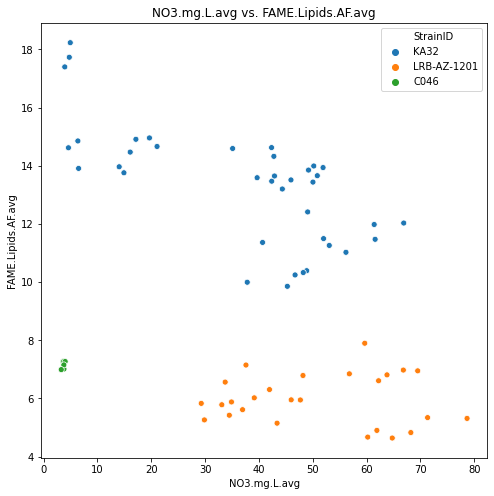

In [ ]:
#@title Graph Generator { run: "auto" }
X = 'NO3.mg.L' #@param ['Protein.AF', 'FAME.Lipids.AF', 'Carbohydrates.AF', 'Duration.days', 'time.between.harvests.days', 'Harvest.Vol..L.', 'AFDW..g.', 'Depth.cm', 'pH_x', 'Temp.C', 'NO3.mg.L', 'P.mg.L', 'OD750', 'Temp.avg (C)', 'Cond (mS.cm)', 'DO (mg.L)', 'DO (%sat)', 'Sal (g.L)', 'PAR (umol.m2.s)', 'AirTemp(C)', 'RH(%)', 'GlobalLightEnergy(W.m2)', 'WindSpeed(km.hr)', 'WDir(deg)', 'Precip.tot(cm)']
Y = 'FAME.Lipids.AF' #@param ['Protein.AF', 'FAME.Lipids.AF', 'Carbohydrates.AF', 'Duration.days', 'time.between.harvests.days', 'Harvest.Vol..L.', 'AFDW..g.', 'Depth.cm', 'pH_x', 'Temp.C', 'NO3.mg.L', 'P.mg.L', 'OD750', 'Temp.avg (C)', 'Cond (mS.cm)', 'DO (mg.L)', 'DO (%sat)', 'Sal (g.L)', 'PAR (umol.m2.s)', 'AirTemp(C)', 'RH(%)', 'GlobalLightEnergy(W.m2)', 'WindSpeed(km.hr)', 'WDir(deg)', 'Precip.tot(cm)']
Species = "All Species" #@param ["Nannochloropsis oceanica (KA32)", "Chlorella vulgaris (LRB-AZ-1201)", "Desmodesmus subspicatus (C046)", "All Species"]
Dataset = "Averages" #@param ["Averages", "Raw Data"]
Hue = "StrainID" #@param ["StrainID", "No Hue"]
Plot = "Scatter" #@param ["Regression", "Scatter"]
Standard_Origin = False #@param {type:"boolean"}

df_used = pd.DataFrame()

# Dataset Sort
if Dataset == 'Averages':
  df_used = average_data
  xtitle = X+'.avg'
  ytitle = Y+'.avg'
elif Dataset == 'Raw Data':
  df_used = combined_data
  xtitle = X
  ytitle = Y

# Strain Sort
if Species == 'Nannochloropsis oceanica (KA32)':
  df_used = df_used.loc[df_used['StrainID'] == 'KA32']
elif Species == 'Chlorella vulgaris (LRB-AZ-1201)':
  df_used = df_used.loc[df_used['StrainID'] == 'LRB-AZ-1201']
elif Species == 'Desmodesmus subspicatus (C046)':
  df_used = df_used.loc[df_used['StrainID'] == 'C046']
elif Species == 'All Species':
  df_used = df_used

# Plot the Data
if Plot == 'Regression' and Hue == 'StrainID':
  sns.lmplot(x=X, y=Y, data=df_used, hue='StrainID', size=7)
  ax = plt.gca()
  ax.set(title=xtitle + ' vs. ' + ytitle, xlabel=xtitle, ylabel=ytitle)
elif Plot == 'Regression' and Hue == 'No Hue':
  sns.lmplot(x=X, y=Y, data=df_used, size=7)
  ax = plt.gca()
  ax.set(title=xtitle + ' vs. ' + ytitle, xlabel=xtitle, ylabel=ytitle)
elif Plot == 'Scatter' and Hue == 'StrainID':
  plt.figure(figsize=(8,8))
  ax = sns.scatterplot(x=X, y=Y, data=df_used, hue='StrainID')
  ax.set(title = xtitle + ' vs. ' + ytitle, xlabel=xtitle, ylabel=ytitle)
elif Plot == 'Scatter' and Hue == 'No Hue':
  plt.figure(figsize=(8,8))
  ax = sns.scatterplot(x=X, y=Y, data=df_used)
  ax.set(title = xtitle + ' vs. ' + ytitle, xlabel=xtitle, ylabel=ytitle)
if Standard_Origin == True:
  ax.set(ylim=(0, None), xlim=(0, None))

# Generate Linear Regression Equation
print('Regression:')
print(scipy.stats.linregress(df_used[X], df_used[Y]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


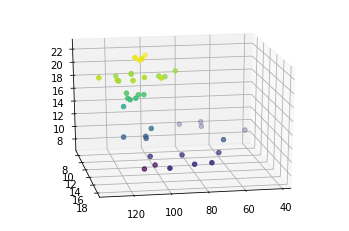

In [ ]:
fig = plt.figure()
plt.xlim(4,16)
ax = plt.axes(projection='3d')

zdata = average_data['Temp.C.avg']
xdata = average_data['DO (%sat).avg']
ydata = average_data['FAME.Lipids.AF.avg']
ax.scatter3D(xdata, ydata, zdata, c=zdata)
ax.view_init(20, 80)


In [ ]:
average_data['FAME.Lipids.AF.avg'].max()

18.2332

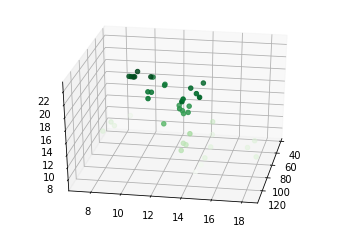

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
zdata = average_data['Temp.C.avg']
xdata = average_data['DO (%sat).avg']
ydata = average_data['FAME.Lipids.AF.avg']
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')
ax.view_init(30, 10)